# Bigram Language Model


## Descripción

En este notebook se presenta un sencillo modelo de aprendizaje automático para generar nuevos nombres que no existen todavía. Se basa en la predicción del carácter más probable que debe aparecer según el carácter previo en el nombre. 
El proceso de predicción se realiza mediante el análisis de *bigramas*, es decir, pares de caracteres contiguos en los nombres existentes. 

La cantidad de apariciones de cada bigrama se almacena en una matriz bidimensional implementada como un tensor de torch. Cada nombre se procesa con un carácter especial, en este caso un punto '.', al inicio y al final. 
Esto permite predecir el carácter de inicio y el final de una palabra de forma más sencilla.

El modelo se evalúa mediante la calidad de las predicciones. Se imprime el resultado del logaritmo de probabilidad negativa (*log likelihood*),tanto en su forma absoluta como promedio. Un valor cercano a cero indica un mejor rendimiento. 

## Implementación

In [1]:
import torch
import matplotlib.pyplot as plt

El fichero *names.txt* contiene más de 32000 nombres. De ahí se obtendrá la probabilidad de cada bigrama, para luego generar caracteres aleatorios sucesivos siguiendo una distribución de probabilidad multinomial.

In [2]:
words = open('names.txt', 'r').read().splitlines()

Preparamos un tensor con torch, en este caso de dos dimensiones (matriz), para guardar las apariciones de los bigramas. La fila corresponde al índice del primer caracter y la columna el índice del segundo carácter. 

Para gestionar los índices de los caracteres se utilizan dos diccionarios: *stoi* e *itos*. El primero contiene el carácter como clave y el índice como valor, sindo el carácter '.' el de índice cero. El segundo diccionario es equivalente al anterior pero invertido, siendo el índice la clave y el carácter el valor. 

In [3]:
N = torch.zeros((27, 27), dtype=torch.int32)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}

Rellenamos el tensor con la cantidad de aparaciones de cada bigrama:

In [4]:
for w in words:
    chs = ['.'] + list(w) + ['.'] 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

Dibujamos un gráfico en forma de matriz para representar el número de apariciones de cada bigrama

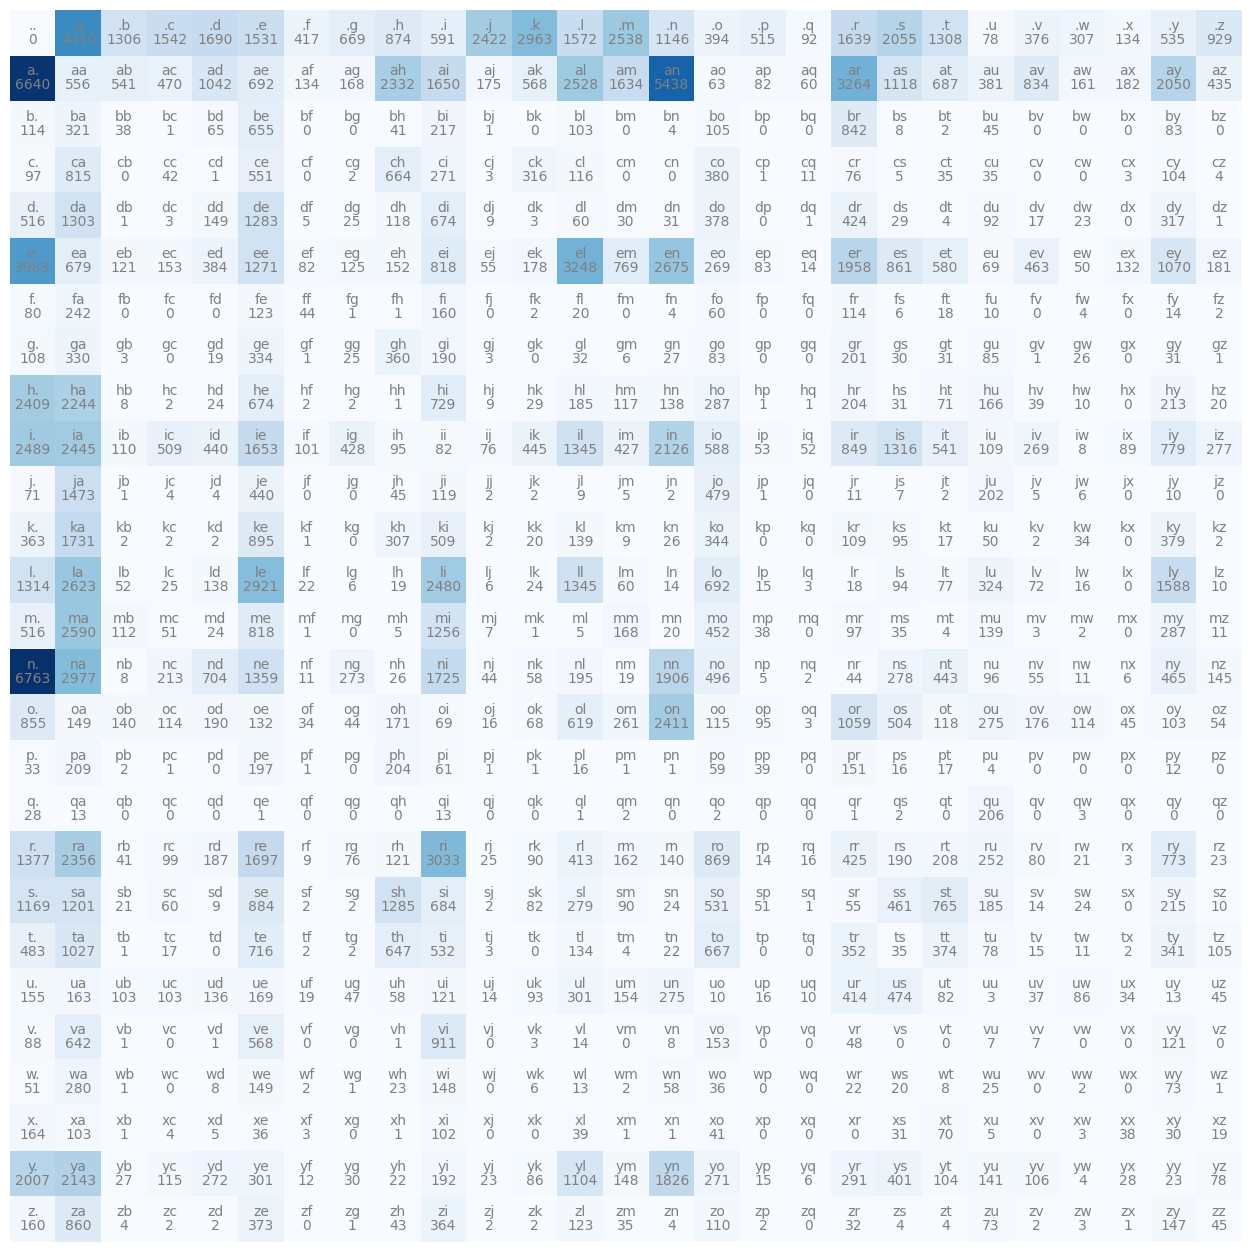

In [5]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')
plt.axis('off')
plt.show()

Calculamos la probabilidad de aparacición normalizada de cada carácter (entre 0 y 1) respecto al carácter anterior. Cabe aclarar que la probabilidad de aparación se calcula individualmente para cada fila, ya que se debe calcular la probabilidad respecto al carácter previo, representado por cada fila.

In [6]:
P = N.float()
P /= P.sum(1, keepdim=True)

Dibujamos el mismo gráfico en forma de matriz pero esta vez representado la probabilidad calculada:

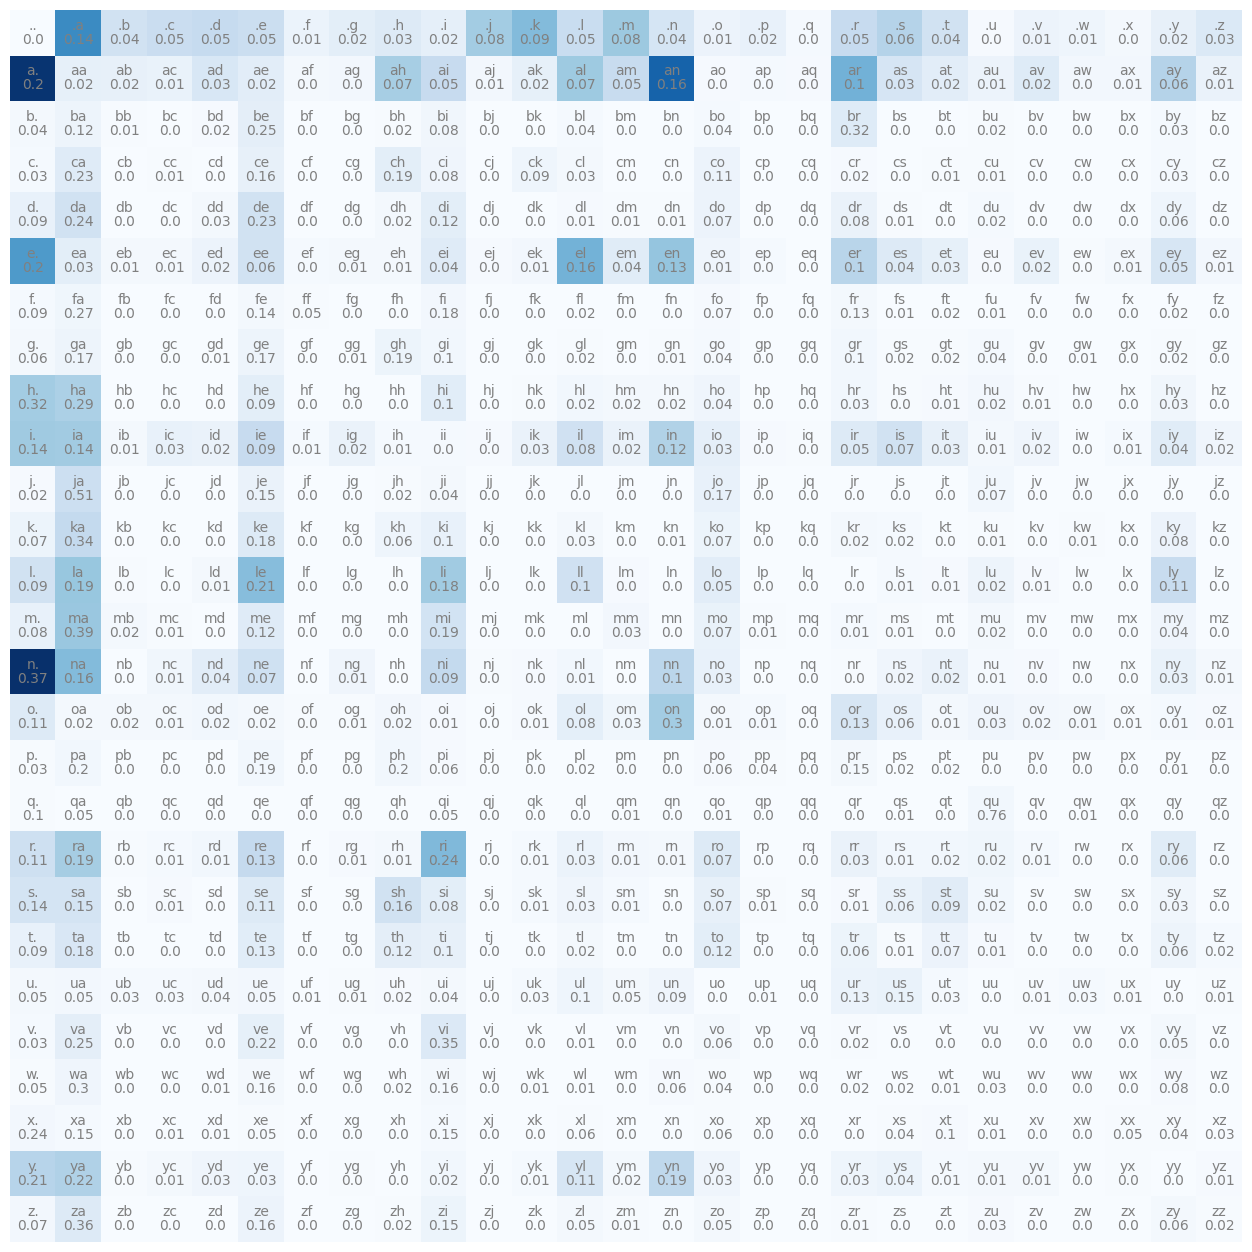

In [7]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, round(P[i, j].item(), 2), ha='center', va='top', color='gray')
plt.axis('off')
plt.show()

Ahora, generamos diez nombres. Cada nuevo nombre comienza con el carácter especial de inicio y, a partir de este, se calcula el siguiente, siguiendo una distribución multinomial de probabilidad hasta que el carácter generado vuelve a ser el especial.

In [8]:
new_names = []
g = torch.Generator().manual_seed(59)
for i in range(10):
    new_name = [] 
    ix = stoi['.']  # Establecemos el caracter especial como inicio 
    while True:
        # Obtenemos un siguiente ix siguiendo una distrubución de probabilidad multinomial
        ix = torch.multinomial(P[ix], num_samples=1, replacement=True, generator=g).item()
        new_name.append(itos[ix])
        if itos[ix] == '.':
            break
    new_names.append(''.join(new_name))
print(new_names)

['ayaha.', 'adeni.', 'wulydanan.', 'mai.', 'vah.', 'jeha.', 'eyaval.', 'asitzlibrsiama.', 'linn.', 'ja.']


Evaluamos la calidad del modelo. Lo que se busca es que ambos resultados sean lo más próximos a cero. Por tanto queremos minimizar está función (de pérdida)

In [9]:
n = 0
log_likelihood = 0.0
for w in words:
    chs = ['.'] + list(w) + ['.'] 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1 

print(f'Log Likelihood (Abs): {-log_likelihood} ')
print(f'Log Likelihood (Avg): {-log_likelihood / n} ')

Log Likelihood (Abs): 559891.75 
Log Likelihood (Avg): 2.454094171524048 


## Implementación con redes neuronales

Primero vamos a crear el conjunto de entrentamiento para la red neuronal. En este caso vamos a seguir trabajando con bigramas, y para ello vamos a crear dos listas. La lista *xs*, contiene el primer carácter de todos los bigramas que aparecen en el conjunto y la lista *yx*, contiene el segundo carácter de todos los bigramas. 

Por tanto, cada bigrama puede ser representado accediendo al mismo índice de la lista *xs* e *ys* para acceder al primer y segundo elemento que compone el bigrama respectivamente.

In [14]:
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.'] 
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(xs)
print(ys)

tensor([ 0,  5, 13,  ..., 25, 26, 24])
tensor([ 5, 13, 13,  ..., 26, 24,  0])


A la hora de alimentar redes neuronales con enteros, suele ser habitual codificar los valores utilizando la técnica de *one-hot encoding*. En este caso, aplicar esta técnica nos permite convertir un valor entero en un vector, lo que suele proporcionar mejores resultados para entrenar redes neuronales. Básicamente, para cada bigrama (x,y) lo que hacemos es crear un vector con la dimensión del número de clases, en este caso el número de caracteres, e indicar con un uno la clase indicada y el resto como cero.

Además, también es habitual y recomendable trabajar con valores flotantes en vez de con enteros. Por ello, una vez aplicada la técnica de codificación convertimos el tensor de enteros en tipos flotantes.

In [17]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()
yenc = F.one_hot(ys, num_classes=27).float()
print(xenc)
print(yenc)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


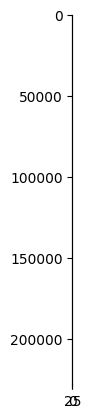

In [19]:
plt.imshow(yenc)